In [14]:
import os
import sys

sys.path.append('/root/diffuser_chain_hd')
# print(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
# exit()


import json
import numpy as np
from os.path import join
import pdb

from diffuser.guides.policies import Policy
import diffuser.datasets as datasets
import diffuser.utils as utils

import argparse


class Parser(utils.Parser):
    dataset: str = 'maze2d-large-v1'
    config: str = 'config.stitched.maze2d_390_r7_non_straight_expl'

#     dataset: str = 'maze2d-large-v2'
#     config: str = 'config.maze2d_390_originalDiffuser_mazexxlarge_test8M_HLarge'



#---------------------------------- setup ----------------------------------#
n_samples = 100

args = Parser().parse_args('diffusion', add_extras=False) # Discovered it later, so had to disable it as I am doing it here, until I test it


[ utils/setup ] Reading config: config.stitched.maze2d_390_r7_non_straight_expl:maze2d_large_v1
[ utils/setup ] Using overrides | config: config.stitched.maze2d_390_r7_non_straight_expl | dataset: maze2d_large_v1
[ utils/setup ] Setting exp_name to: stitched_diffuser_diffuser/H384_T256_J1_AW1_R7_linear-non_straight-expl
[ utils/setup ] Made savepath: logs/maze2d-large-v1/stitched_diffuser_diffuser/H384_T256_J1_AW1_R7_linear-non_straight-expl
[ utils/setup ] Saved args to logs/maze2d-large-v1/stitched_diffuser_diffuser/H384_T256_J1_AW1_R7_linear-non_straight-expl/args.json


In [15]:
env = datasets.load_environment(args.dataset)

args.dataset

'maze2d-large-v1'

In [16]:
use_stitched_data = args.use_stitched_data if hasattr(args, "use_stitched_data") else False
use_short_data = args.use_short_data if hasattr(args, "use_short_data") else False
max_round = args.max_round if hasattr(args, "max_round") else -1
# Previous models used only the 10k last episodes -> I do not want to mess up with their training
max_n_episodes = args.max_n_episodes if hasattr(args, "max_n_episodes") else 10000
stitched_method = args.stitched_method if hasattr(args, "stitched_method") else "linear" # to enable backward compatibility

dataset_config = utils.Config(
    args.loader,
    savepath=(args.savepath, "dataset_config.pkl"),
    env=args.dataset,
    horizon=args.horizon,
    normalizer=args.normalizer,
    preprocess_fns=args.preprocess_fns,
    use_padding=args.use_padding,
    max_path_length=args.max_path_length,
    jump=args.jump,
    jump_action=args.jump_action,
    use_stitched_data=use_stitched_data,
    use_short_data=use_short_data,
    max_round=max_round,
    max_n_episodes=max_n_episodes,
    stitched_method=stitched_method,
)

render_config = utils.Config(
    args.renderer,
    savepath=(args.savepath, "render_config.pkl"),
    env=args.dataset,
)
args.horizon

[ utils/config ] Imported diffuser.datasets:GoalDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.GoalDataset'>
    env: maze2d-large-v1
    horizon: 384
    jump: 1
    jump_action: 1
    max_n_episodes: 100000
    max_path_length: 40000
    max_round: 7
    normalizer: LimitsNormalizer
    preprocess_fns: []
    stitched_method: linear-non_straight-expl
    use_padding: False
    use_short_data: True
    use_stitched_data: True

[ utils/config ] Saved config to: logs/maze2d-large-v1/stitched_diffuser_diffuser/H384_T256_J1_AW1_R7_linear-non_straight-expl/dataset_config.pkl

[ utils/config ] Imported diffuser.utils:Maze2dRenderer

[utils/config ] Config: <class 'diffuser.utils.rendering.Maze2dRenderer'>
    env: maze2d-large-v1

[ utils/config ] Saved config to: logs/maze2d-large-v1/stitched_diffuser_diffuser/H384_T256_J1_AW1_R7_linear-non_straight-expl/render_config.pkl



384

In [17]:
dataset = dataset_config()
renderer = render_config()

Using the short dataset
[ utils/preprocessing ] Segmented maze2d-large-v1 | 6838 paths | min length: 130 | max length: 170 | mean length: 146.2009359461831
Using the stitched dataset
Loading /root/diffuser_chain_hd/data/maze2d-large-v1-linear-non_straight-expl-round_1-postprocess.pkl
[ utils/preprocessing ] Segmented maze2d-large-v1 | 3689 paths | min length: 219 | max length: 358 | mean length: 280.5239902412578
Loading /root/diffuser_chain_hd/data/maze2d-large-v1-linear-non_straight-expl-round_2-postprocess.pkl
[ utils/preprocessing ] Segmented maze2d-large-v1 | 2671 paths | min length: 296 | max length: 485 | mean length: 384.212280044927
Loading /root/diffuser_chain_hd/data/maze2d-large-v1-linear-non_straight-expl-round_3-postprocess.pkl
[ utils/preprocessing ] Segmented maze2d-large-v1 | 2107 paths | min length: 364 | max length: 582 | mean length: 485.58851447555764
Loading /root/diffuser_chain_hd/data/maze2d-large-v1-linear-non_straight-expl-round_4-postprocess.pkl
[ utils/prepr

[140 139 154 ... 752 874 946]


(array([6840., 3077., 1971., 1964., 1551., 1372., 1187., 1037.,  789.,
         126.]),
 array([ 129. ,  220.6,  312.2,  403.8,  495.4,  587. ,  678.6,  770.2,
         861.8,  953.4, 1045. ]),
 <BarContainer object of 10 artists>)

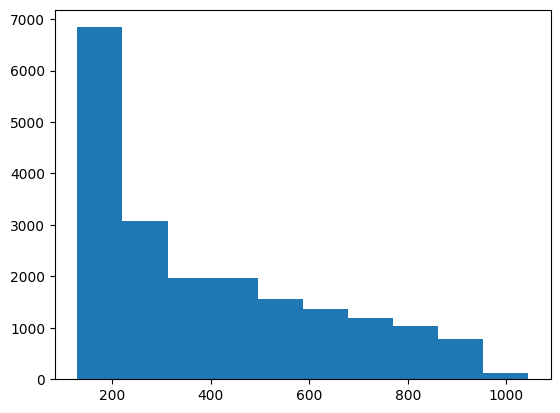

In [7]:
import matplotlib.pyplot as plt
print(dataset.path_lengths)
plt.hist(dataset.path_lengths)

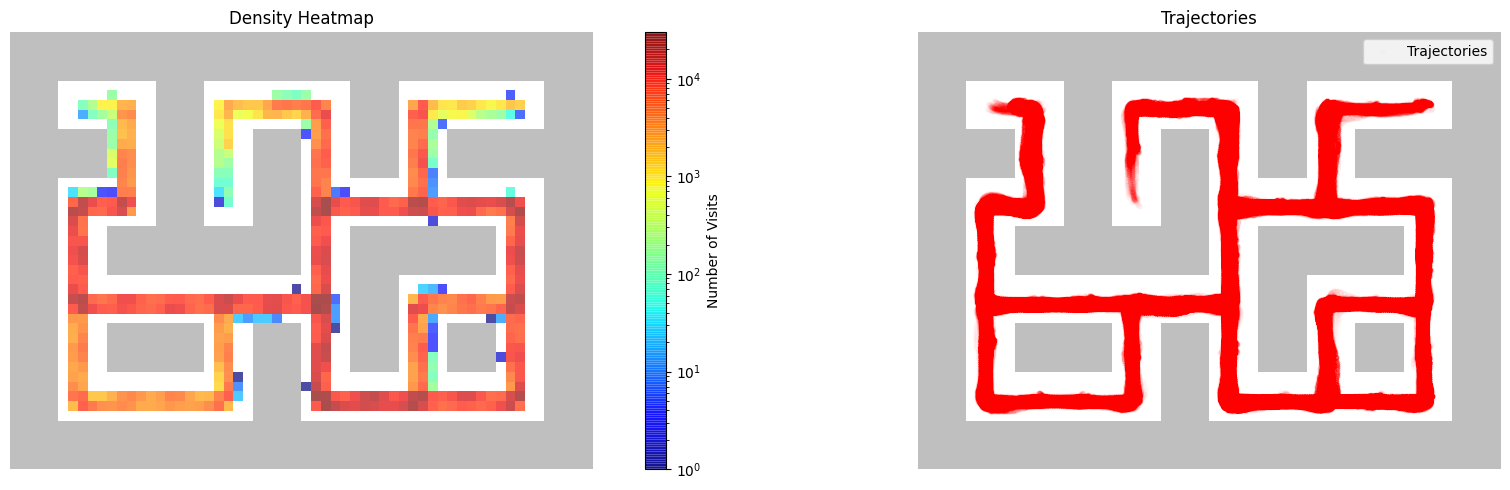

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import gym
import d4rl

def draw_aligned_heatmap_on_environment(env, num_trajs=1000, histogram_scale=5):
    _background = env.maze_arr == 10 

    x_points = []
    z_points = []
    for i in range(num_trajs):
        idx = np.random.randint(0, len(dataset))
        trj = dataset.normalizer.unnormalize(dataset[idx].trajectories[:,dataset.normalizer.action_dim:], "observations")
        x_points.extend(trj[:, 1])
        z_points.extend(trj[:, 0])

    x_points = np.array(x_points)
    z_points = np.array(z_points)

    min_x, max_x = 0, _background.shape[1]
    min_z, max_z = 0, _background.shape[0]


    # Calculate histogram bins
    bins_x = int(histogram_scale * (max_x - min_x))
    bins_z = int(histogram_scale * (max_z - min_z))
    pos_traj, x_edges, z_edges = np.histogram2d(x_points, z_points, bins=[bins_x, bins_z], range=[[min_x-0.5, max_x-0.5], [min_z-0.5, max_z-0.5]])
    pos_traj = pos_traj.T
    pos_traj = np.flipud(pos_traj)

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    ax = axes[0]

    # Plot environment background
    ax.imshow(
        _background * 0.5,
        cmap=plt.cm.binary,
        vmin=0,
        vmax=1,
        extent=[min_x, max_x, min_z, max_z],
        origin='lower',
        alpha=0.5,
    )

    # Plot heatmap
    cax = ax.imshow(
        pos_traj,
        cmap='jet',
        interpolation='nearest',
        norm=LogNorm(),
        extent=[min_x, max_x, min_z, max_z],
        alpha=0.7,
    )
    plt.colorbar(cax, ax=ax, label='Number of Visits')
    ax.axis("off")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Density Heatmap')


    ax = axes[1]

    ax.imshow(
        _background * 0.5,
        cmap=plt.cm.binary,
        vmin=0,
        vmax=1,
        origin='lower',
        alpha=0.5,
    )

    ax.scatter(x_points, z_points, color='red', s=10, alpha=0.01, label='Trajectories')
    ax.axis("off")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    ax.set_title('Trajectories')

    plt.legend()
    plt.tight_layout()
    plt.show()

env = datasets.load_environment(args.dataset)
draw_aligned_heatmap_on_environment(env, num_trajs=10000, histogram_scale=5)